# **Necessary package**

In [1]:
! pip install keras_core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 5.4 MB/s eta 0:00:00


# **Import libraries**

In [2]:
# Global libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import nltk
from nltk.corpus import stopwords

# Function to plot WordCloud
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

# Tensorflow/Keras
import tensorflow as tf
import keras_core as keras
from keras import Sequential
from keras.layers import Input, TextVectorization, Embedding, GlobalAveragePooling1D, Dense
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,CSVLogger
#ModelCheckpoint : saves the model's weights or the entire model at specific intervals during training.
#ReduceLROnPlateau : reduces the learning rate when validation loss has stopped improving.
#CSVLogger : saves the training and validation metrics to a CSV file during training.

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report, roc_curve, auc
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer


os.environ["KERAS_BACKEND"] = "tensorflow"

# Set Seed for Reproducibility
keras.utils.set_random_seed(42)

# Use mixed precision to speed up all training.
#This means that certain parts of the network (e.g., weights, gradients) will be stored and computed in float16, which requires less memory compared to the default float32.
#However, some parts that could lead to numerical instability (e.g., activations) will still be stored and computed in the higher precision float32.
keras.mixed_precision.set_global_policy("mixed_float16")

# Check Versions
# print("TensorFlow:", tf.__version__)
# print("Keras:", keras.__version__)

Using TensorFlow backend


In [3]:
import warnings
warnings.filterwarnings('ignore')

# **Loading Dataset**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df_train_essays = pd.read_csv("/content/drive/MyDrive/train_essays.csv")
df_train_essays.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


# **EDA and Preprossecing**

In [6]:
print('Shape of dataset :', df_train_essays.shape)

Shape of dataset : (1378, 4)


In [7]:
#get information
print(df_train_essays.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB
None


In [ ]:
#checking missing value
df_train_essays.isna().sum()

id           0
prompt_id    0
text         0
generated    0
dtype: int64

Dataset has no missing value.

In [ ]:
#checking duplicated value
df_train_essays.duplicated().sum()

0

Dataset has no duplicated value.

 The following function will be used to to downcast numerical columns to more memory-efficient types, hence improving its memory usage.

In [8]:
def compress(df, verbose=True):
    """
    Reduces the size of the DataFrame by downcasting numerical columns
    """
    #It calculates the input size of the DataFrame by summing the memory usage of all columns and dividing by 1024^2 to convert it to megabytes (MB)
    input_size = df.memory_usage(index=True).sum() / (1024 ** 2)
    if verbose:
        print("Old dataframe size:", round(input_size, 2), 'MB')#If "verbose" is True, it prints the old size of the DataFrame.

    in_size = df.memory_usage(index=True).sum()
    dtype_before = df.dtypes.copy()  # Copy of original data types

    for col in df.select_dtypes(include=['float64', 'int64']):
        col_type = df[col].dtype
        col_min, col_max = df[col].min(), df[col].max()

        if col_type == 'int64':
            if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)
        elif col_type == 'float64':
            ## float16 warns of overflow
            # if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
            #     df[col] = df[col].astype(np.float16)
            if col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            elif col_min > np.finfo(np.float64).min and col_max < np.finfo(np.float64).max:
                df[col] = df[col].astype(np.float64)

    out_size = df.memory_usage(index=True).sum()
    ratio = (1 - round(out_size / in_size, 2)) * 100

    if verbose:
        print("Optimized size by {}%".format(round(ratio, 2)))
        print("New DataFrame size:", round(out_size / (1024 ** 2), 2), "MB")

    # Filter only numerical columns for comparison
    numeric_columns = df.select_dtypes(include=['float32', 'float64', 'int8', 'int16', 'int32', 'int64'])
    dtype_after = numeric_columns.dtypes.copy()  # Copy of data types after compression

    # Create a comparison DataFrame
    comparison_df = pd.DataFrame({'Before': dtype_before[numeric_columns.columns], 'After': dtype_after})
    comparison_df['Size Reduction'] = ratio

    return df, comparison_df

In [9]:
# Compression

# Compress dataframe
df_train_essays, comparison_df = compress(df_train_essays, verbose=True)

# Check compression
comparison_df

Old dataframe size: 0.04 MB
Optimized size by 44.0%
New DataFrame size: 0.02 MB


,Before,After,Size Reduction
prompt_id,int64,int8,44.0
generated,int64,int8,44.0


In [ ]:
# Checking the first essay text

df_train_essays.text[0]

'Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.\n\nIn like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go. Article

In [10]:
# Generate WordCloud

def generate_wordcloud_subplot(df, label_value, subplot_position, max_words=1000, width=800, height=400, top_n = 10):
    """
    Generate a word cloud for a specific label value and display it in a subplot.

    Args:
        df (DataFrame): The DataFrame containing text data and labels.
        label_value (int): The label value for which to generate the word cloud.
        subplot_position (int): The position of the subplot where the word cloud will be displayed.
        max_words (int, optional): Maximum number of words to include in the word cloud. Default is 1000.
        width (int, optional): Width of the word cloud image. Default is 800.
        height (int, optional): Height of the word cloud image. Default is 400.

    Returns:
        None
    """

    # Select the text subset for the specified label value
    text_subset = df[df.generated == label_value].text

    # Define stopwords to be excluded
    stopwords = set(STOPWORDS)

    # Create a WordCloud object with specified parameters
    wc = WordCloud(max_words=max_words, width=width, height=height, stopwords=stopwords)

    # Generate the word cloud from the selected text subset
    wc.generate(" ".join(text_subset))

    # Create a subplot and display the word cloud
    plt.subplot(subplot_position)
    plt.imshow(wc, interpolation='bilinear')

    # Set the title for the word cloud plot
    title = f'WordCloud for Label {label_value} ({("Student" if label_value == 0 else "AI")})'
    plt.title(title)

    # Count occurrences of words in the text subset
    words_count = Counter(" ".join(text_subset).split())
    top_words = words_count.most_common(top_n)
    bottom_words = words_count.most_common()[:-top_n-1:-1]  # Extract least common words

    # Print the most common words
    print(f"Top {top_n} words for Label {label_value}:")
    for idx, (word, count) in enumerate(top_words, start=1):
        print(f"{idx}. {word}: {count} times")
    print("------------------------------")

    # Print the least common words
    print(f"Least {top_n} words for Label {label_value}:")
    for idx, (word, count) in enumerate(bottom_words, start=1):
        print(f"{idx}. {word}: {count} times")
    print("------------------------------")

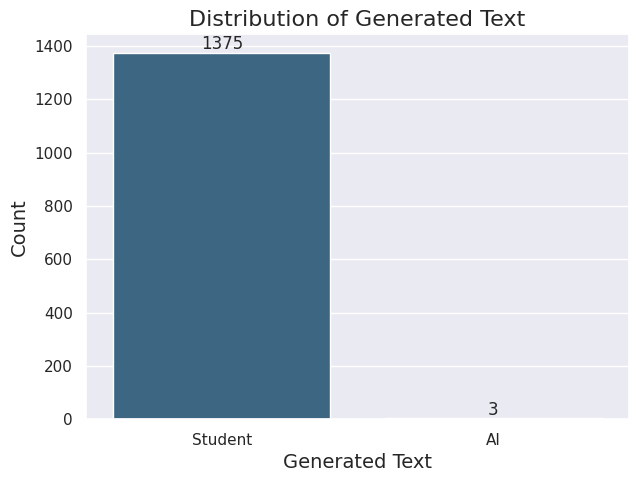

In [ ]:
# Distribution of Generated Text

# Set Figure
plt.figure(figsize=(7, 5))
#sns.set(style="darkgrid")

# Create the count plot
ax = sns.countplot(data=df_train_essays, x="generated", palette="viridis")

# Mapping x-axis labels
ax.set_xticklabels(["Student", "AI"])

ax.bar_label(container=ax.containers[0], fontsize=12)
ax.bar_label(container=ax.containers[1], fontsize=12)

# Set title and labels with increased font sizes
ax.set_title("Distribution of Generated Text", fontsize=16)
ax.set_xlabel("Generated Text", fontsize=14)
ax.set_ylabel("Count", fontsize=14)

plt.show()

Dataset is very imbalance

***Balance dataset***

In [11]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
%cd /content/drive/MyDrive/Kaggle/

/content/drive/MyDrive/Kaggle


In [12]:
!kaggle datasets download -d thedrcat/daigt-proper-train-dataset

daigt-proper-train-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [14]:
!unzip daigt-proper-train-dataset.zip

Archive:  daigt-proper-train-dataset.zip
replace train_drcat_01.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [16]:
#Import external dataset

ext1 = pd.read_csv('/content/drive/MyDrive/Kaggle/train_drcat_04.csv')

In [17]:
ext1.head()

,essay_id,text,label,source,prompt,fold
0,E897534557AF,"In recent years, technology has had a profoun...",1,mistral7binstruct_v2,\nTask: Write an essay discussing the positive...,1
1,DFBA34FFE11D,Should students participate in an extracurricu...,0,persuade_corpus,NaN,2
2,af37ecf5,The electoral college is a symbol of mockery a...,0,train_essays,NaN,5
3,5EC2696BAD78,This is why I think the principle should allow...,0,persuade_corpus,NaN,8
4,llama_70b_v1843,I strongly believe that meditation and mindful...,1,llama_70b_v1,Some schools have implemented meditation and m...,0


In [ ]:
ext1.shape

(44206, 6)

In [ ]:
# Check duplicates

# Get the number of rows with duplicates
duplicates = ext1.duplicated().sum()

# Print the number of rows before and after
print(f"Number of rows with duplicates: {duplicates}")

Number of rows with duplicates: 0


In [18]:
# Compression

# Compress dataframe
ext1, comparison_df = compress(ext1, verbose=True)

# Check compression
comparison_df

Old dataframe size: 2.02 MB
Optimized size by 29.0%
New DataFrame size: 1.43 MB


,Before,After,Size Reduction
label,int64,int8,29.0
fold,int64,int8,29.0


In [19]:
# Drop Columns

ext1.drop(["essay_id", "fold", "source", "prompt"], inplace=True, axis=1)

ext1.head()

,text,label
0,"In recent years, technology has had a profoun...",1
1,Should students participate in an extracurricu...,0
2,The electoral college is a symbol of mockery a...,0
3,This is why I think the principle should allow...,0
4,I strongly believe that meditation and mindful...,1


In [20]:
# Rename label column

ext1.rename(columns = {"label":"generated"}, inplace=True)

ext1.head()

,text,generated
0,"In recent years, technology has had a profoun...",1
1,Should students participate in an extracurricu...,0
2,The electoral college is a symbol of mockery a...,0
3,This is why I think the principle should allow...,0
4,I strongly believe that meditation and mindful...,1


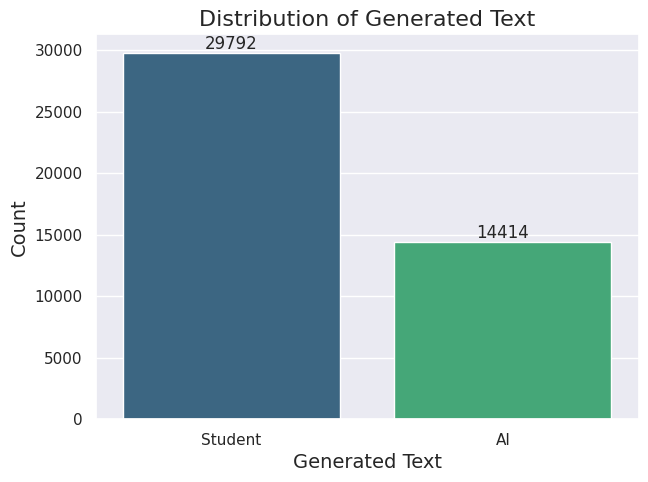

In [ ]:
# Distribution of Generated Text in the External Dataset

# Set Figure
plt.figure(figsize=(7, 5))

# Create the count plot
ax = sns.countplot(data=ext1, x="generated", palette="viridis")

# Mapping x-axis labels
ax.set_xticklabels(["Student", "AI"])

ax.bar_label(ax.containers[0], fontsize=12)
ax.bar_label(ax.containers[1], fontsize=12)


# Set title and labels with increased font sizes
ax.set_title("Distribution of Generated Text", fontsize=16)
ax.set_xlabel("Generated Text", fontsize=14)
ax.set_ylabel("Count", fontsize=14)

plt.show()

Top 10 words for Label 1:
1. and: 174600 times
2. to: 168789 times
3. the: 141448 times
4. a: 109251 times
5. of: 95482 times
6. in: 66445 times
7. can: 65738 times
8. that: 57707 times
9. is: 52925 times
10. for: 47853 times
------------------------------
Least 10 words for Label 1:
1. slim,: 1 times
2. photo,: 1 times
3. shanties: 1 times
4. cobblestone: 1 times
5. Boston's: 1 times
6. Sumter: 1 times
7. Fort: 1 times
8. eastern: 1 times
9. glided: 1 times
10. manning: 1 times
------------------------------
Top 10 words for Label 0:
1. the: 522093 times
2. to: 454303 times
3. and: 297609 times
4. a: 290994 times
5. of: 232306 times
6. that: 194649 times
7. is: 185182 times
8. in: 174815 times
9. you: 148988 times
10. be: 142417 times
------------------------------
Least 10 words for Label 0:
1. END!!!!!!: 1 times
2. A-.: 1 times
3. spans;: 1 times
4. mayonnaise.: 1 times
5. addiction",: 1 times
6. provides!",: 1 times
7. week",: 1 times
8. team!",: 1 times
9. 2+: 1 times
10. "luxury"

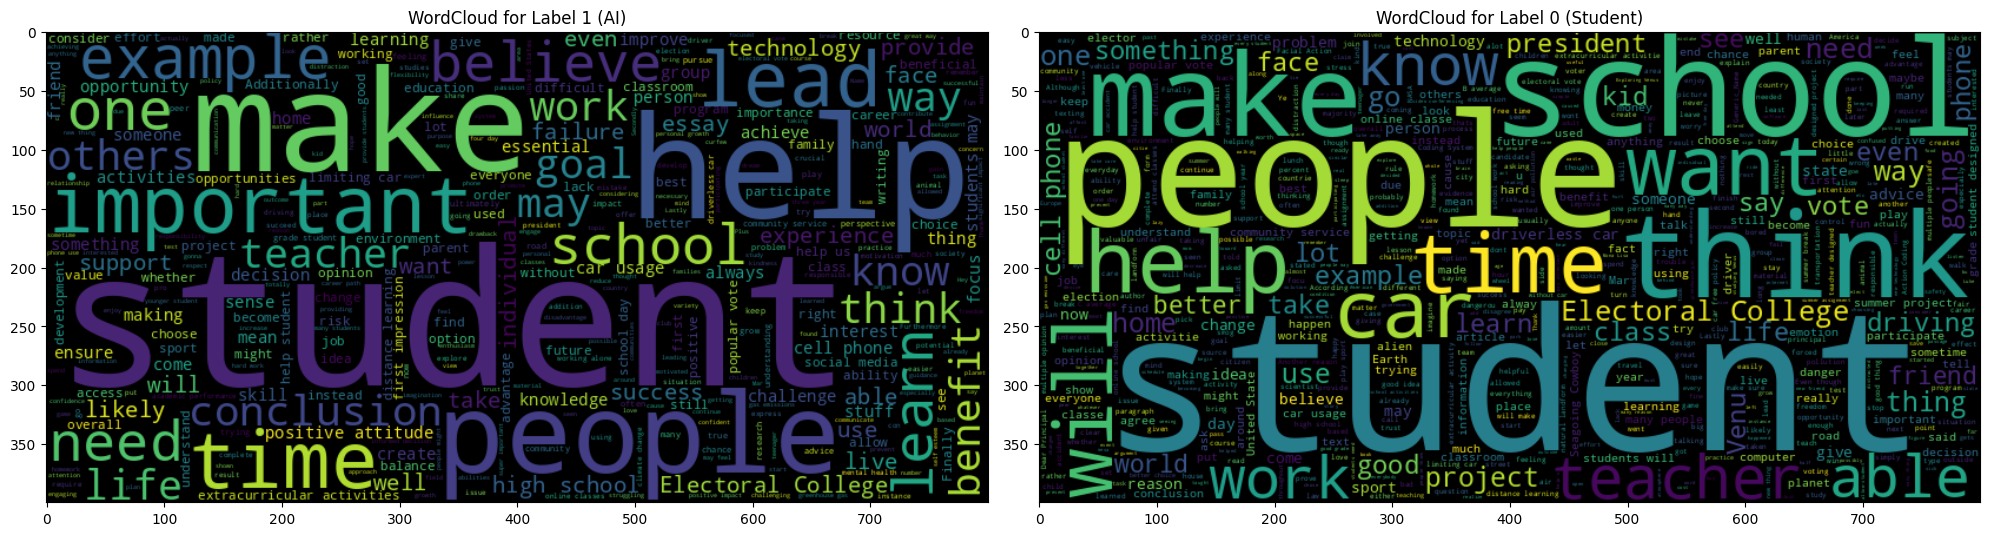

In [21]:
# Plot WordCloud

# Create a 1x2 grid of subplots
plt.figure(figsize=(20, 10))

# Generate WordCloud for label_value = 1 (subplot 1)
generate_wordcloud_subplot(ext1, label_value=1, subplot_position=121, top_n = 10)

# Generate WordCloud for label_value = 0 (subplot 2)
generate_wordcloud_subplot(ext1, label_value=0, subplot_position=122, top_n = 10)

plt.tight_layout()  # Adjust spacing between subplots

plt.show()

In [22]:
# Clean Text
def clean_text(text):
    # Replace actual newline and carriage return characters with whitespace
    text = text.replace("\n", " ")
    text = text.replace("\r", " ")

    # Drop punctuation
    text = re.sub(r"\p{P}", " ", text)

    # Remove extra spaces
    text = re.sub(r"\s+", " ", text)

    # Remove leading and trailing whitespace
    text = text.strip()

    # Lower text
    text = text.lower()

    # Remove numbers
    text = re.sub(r"\d+", "", text)


    return text

# Apply the clean_text function to the 'text' column in the DataFrame
ext1['text'] = ext1['text'].apply(clean_text)

# Change contractions
contractions = {
    r'\b(can\'t)\b': 'cannot',
    r'\b(don\'t)\b': 'do not',
    r'\b(won\'t)\b': 'will not',
}

# Iterate through contractions and apply replacements to the entire DataFrame column
for pattern, replacement in contractions.items():
    ext1['text'] = ext1['text'].apply(lambda x: re.sub(pattern, replacement, x, flags=re.IGNORECASE))

In [23]:
nltk.download('stopwords')
stopwords_list = stopwords.words('english')
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [24]:
len(stopwords_list)

179

In [25]:
# Remove Stopwords

def remove_stopwords(sentence):
    words = sentence.split()
    filtered_words = [word for word in words if word.lower() not in stopwords_list]
    return ' '.join(filtered_words)

# Apply the function to the 'text' column
ext1['text'] = ext1['text'].apply(remove_stopwords)

Top 10 words for Label 1:
1. students: 40002 times
2. like: 24796 times
3. school: 19488 times
4. also: 18491 times
5. may: 18065 times
6. people: 17289 times
7. help: 17088 times
8. time: 15944 times
9. important: 15298 times
10. make: 13722 times
------------------------------
Least 10 words for Label 1:
1. shanties: 1 times
2. cobblestone: 1 times
3. sumter: 1 times
4. glided: 1 times
5. manning: 1 times
6. suprise: 1 times
7. afraisd: 1 times
8. doll: 1 times
9. testimonials: 1 times
10. kindhearted: 1 times
------------------------------
Top 10 words for Label 0:
1. students: 103956 times
2. people: 83198 times
3. would: 81130 times
4. school: 67488 times
5. get: 47266 times
6. could: 44364 times
7. like: 42852 times
8. time: 42036 times
9. one: 41297 times
10. help: 41110 times
------------------------------
Least 10 words for Label 0:
1. congestian: 1 times
2. breaki: 1 times
3. senerios: 1 times
4. myhead: 1 times
5. wrried: 1 times
6. alal: 1 times
7. eyesoff: 1 times
8. think

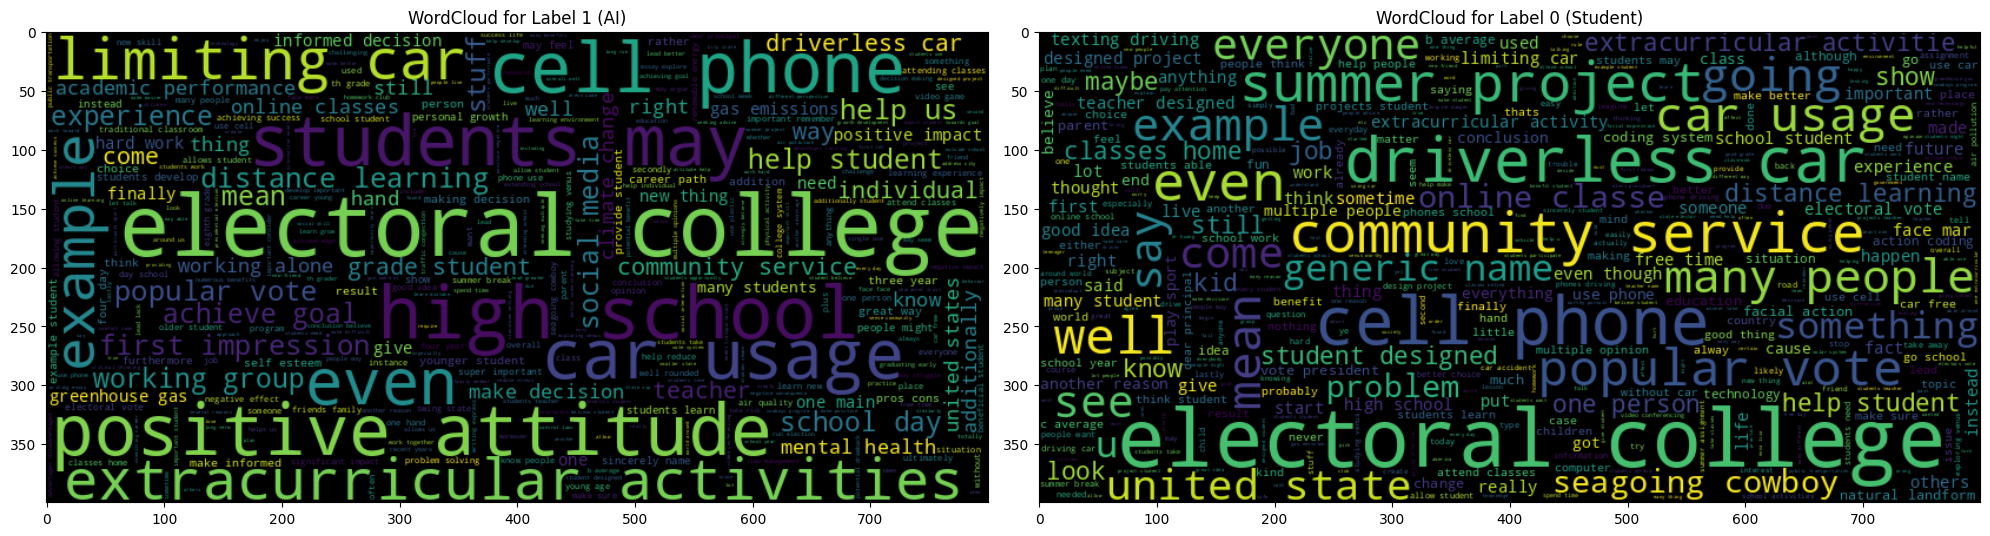

In [27]:
# Plot WordCloud

# Create a 1x2 grid of subplots
plt.figure(figsize=(20, 10))

# Generate WordCloud for label_value = 1 (subplot 1)
generate_wordcloud_subplot(ext1, label_value=1, subplot_position=121, top_n = 10)

# Generate WordCloud for label_value = 0 (subplot 2)
generate_wordcloud_subplot(ext1, label_value=0, subplot_position=122, top_n = 10)


plt.tight_layout()  # Adjust spacing between subplots

plt.show()

In [28]:
# Copy the final_df as df_model

df_model = ext1.copy()

df_model.generated.value_counts()

0    29792
1    14414
Name: generated, dtype: int64

In [29]:
# Create a shuffled df for a good label distribution

print("Before shuffling:", df_model.shape)

# Shuffle the DataFrame with the specified random seed
shuffled_df = df_model.sample(frac=1, random_state=42)

print("After shuffling:", df_model.shape)

Before shuffling: (44206, 2)
After shuffling: (44206, 2)


In [30]:
# Create a train/val/test split
X = shuffled_df["text"]
y = shuffled_df["generated"]


# Split the data into train, validation, and test sets (80% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display the shapes of the train, validation, and test sets
print("X_train shape:", X_train.shape)
print("X_validation shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_validation shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (30944,)
X_validation shape: (6631,)
X_test shape: (6631,)
y_train shape: (30944,)
y_validation shape: (6631,)
y_test shape: (6631,)


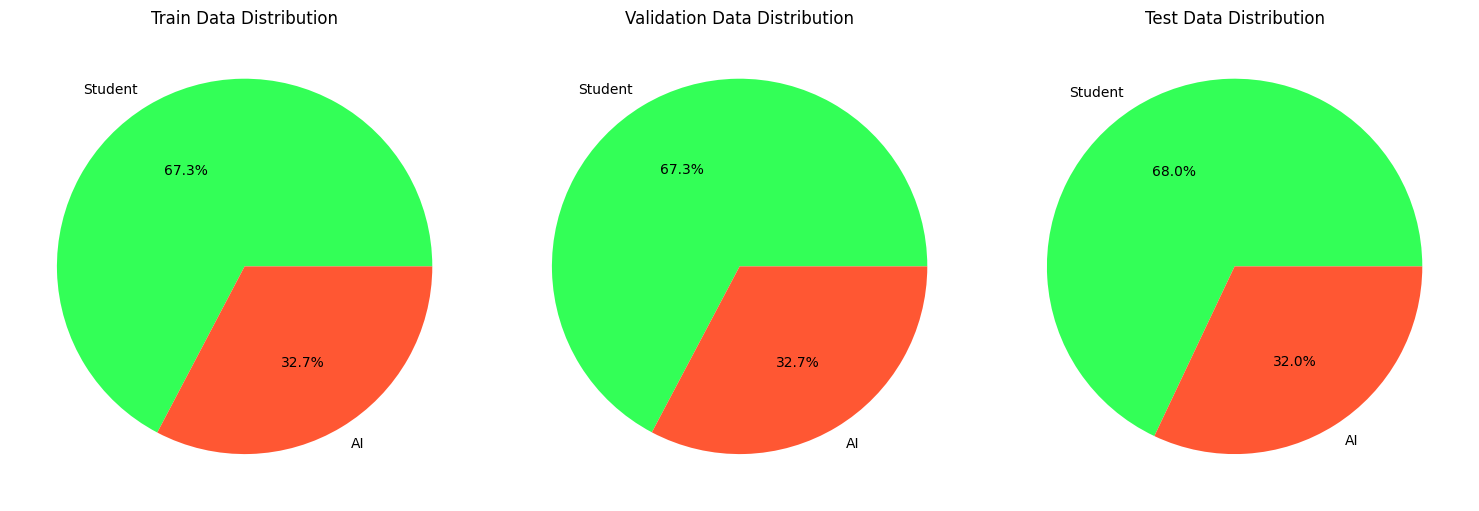

In [31]:
# Get label counts for train, validation, and test data
train_label_counts = y_train.value_counts()
val_label_counts = y_val.value_counts()
test_label_counts = y_test.value_counts()

# Define custom labels for visualization
custom_labels = {0: 'Student', 1: 'AI'}

# Replace labels for visualization purposes
train_labels_visual = train_label_counts.rename(custom_labels)
val_labels_visual = val_label_counts.rename(custom_labels)
test_labels_visual = test_label_counts.rename(custom_labels)

# Define custom colors for each label
label_colors = {'Student': '#33FF57', 'AI': '#FF5733'}

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Subplot 1: Train data distribution
wedges, texts, autotexts = axes[0].pie(train_labels_visual, labels=train_labels_visual.index, autopct='%1.1f%%', colors=[label_colors[label] for label in train_labels_visual.index])
axes[0].set_title('Train Data Distribution')

# Subplot 2: Validation data distribution
wedges, texts, autotexts = axes[1].pie(val_labels_visual, labels=val_labels_visual.index, autopct='%1.1f%%', colors=[label_colors[label] for label in val_labels_visual.index])
axes[1].set_title('Validation Data Distribution')

# Subplot 3: Test data distribution
wedges, texts, autotexts = axes[2].pie(test_labels_visual, labels=test_labels_visual.index, autopct='%1.1f%%', colors=[label_colors[label] for label in test_labels_visual.index])
axes[2].set_title('Test Data Distribution')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# **Bagging**

In [32]:
#convert text data into a vectorized representation via TF-IDF
vectorizer = TfidfVectorizer(min_df=2, max_features= 10000) # word must appear in at least 2 documents to be considered
                                                            # maximum number of features (words) = 10,000

X_train_tfidf_vectorized = vectorizer.fit_transform(X_train).toarray()
X_val_tfidf_vectorized = vectorizer.transform(X_val).toarray()
X_test_tfidf_vectorized = vectorizer.transform(X_test).toarray()

In [33]:
bag_model = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'))

bag_model.fit(X_train_tfidf_vectorized, y_train)
bag_predictions = bag_model.predict(X_test_tfidf_vectorized)

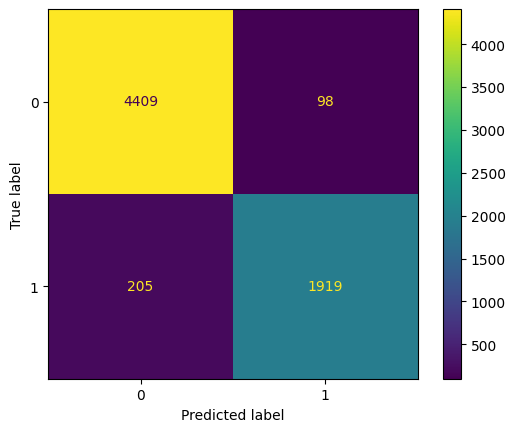

In [34]:
# Plot confusion matrix

bagging_cm = confusion_matrix(y_test, bag_predictions)
bagging_plot = ConfusionMatrixDisplay(confusion_matrix=bagging_cm)

bagging_plot.plot()
plt.show()

In [35]:
print(classification_report(y_test, bag_predictions))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4507
           1       0.95      0.90      0.93      2124

    accuracy                           0.95      6631
   macro avg       0.95      0.94      0.95      6631
weighted avg       0.95      0.95      0.95      6631



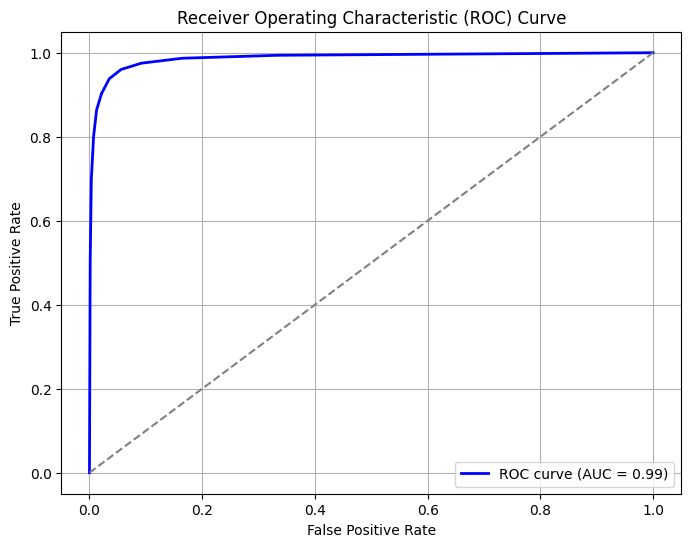

In [36]:
# AUC -  ROC Curve

# Predict probabilities on the test set
y_pred_proba = bag_model.predict_proba(X_test_tfidf_vectorized)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Set labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Set title and legend
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

Good result

In [37]:
ada_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=20)

ada_model.fit(X_train_tfidf_vectorized, y_train)
ada_predictions = ada_model.predict(X_test_tfidf_vectorized)


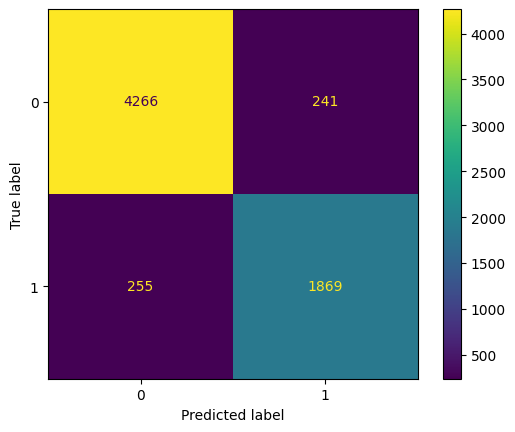

In [38]:
# Plot confusion matrix

ada_cm = confusion_matrix(y_test, ada_predictions)
ada_plot = ConfusionMatrixDisplay(confusion_matrix=ada_cm)

ada_plot.plot()
plt.show()

In [39]:
print(classification_report(y_test, ada_predictions))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      4507
           1       0.89      0.88      0.88      2124

    accuracy                           0.93      6631
   macro avg       0.91      0.91      0.91      6631
weighted avg       0.93      0.93      0.93      6631



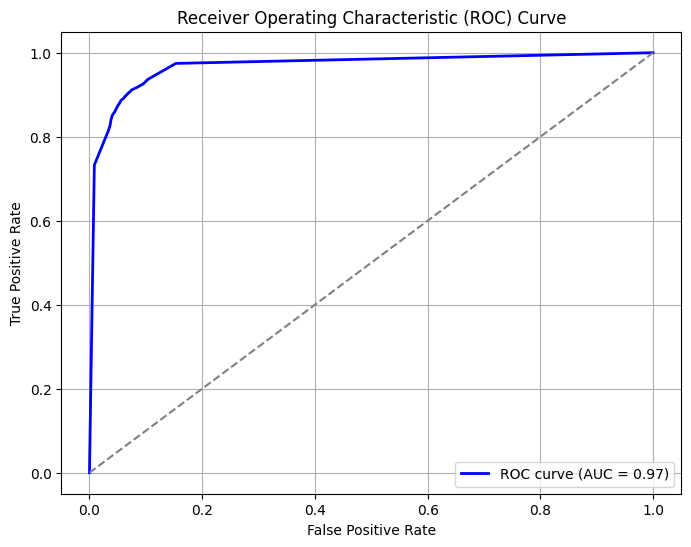

In [40]:
# AUC -  ROC Curve

# Predict probabilities on the test set
y_pred_proba = ada_model.predict_proba(X_test_tfidf_vectorized)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Set labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Set title and legend
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

Relatively good result.

```
# This is formatted as code
```



# **Custom Neural Network**

***Vectorization process***

First calculates and prints the size of the vocabulary, which represents the number of unique tokens in the text data. The vocabulary size is useful for understanding the richness and diversity of the text

In [41]:
# Check the max vocaulary size

text_vectorizer = TextVectorization(split="whitespace", output_mode="int")

# Fit the text vectorizer
text_vectorizer.adapt(X)

# Get the number of unique tokens in the vocabulary
vocab_size = len(text_vectorizer.get_vocabulary())

# Print the vocabulary size
print("Vocabulary size:", vocab_size)

Vocabulary size: 79988


In below : Customizing the maximum vocabulary size, calculating the sequence length based on the average number of tokens, and configuring the TextVectorization layer accordingly.

In [42]:
# Setup text vectorization with custom variables

# Set the maximum vocabulary size
# max_vocab_size = 10000
max_vocab_size = vocab_size

# Calculate the maximum sequence length based on the average number of tokens in training data
average_tokens_per_sequence = round(sum([len(text.split()) for text in X_train]) / len(X_train))

# Create and configure the TextVectorization layer
text_vectorizer = TextVectorization(
    max_tokens=max_vocab_size,
#     ngrams=(3,5),
    output_mode="int",
    output_sequence_length=average_tokens_per_sequence,
    pad_to_max_tokens=True
)

# Adapt the TextVectorization layer to the training text
if len(X_train) > 0:
    text_vectorizer.adapt(X_train)
else:
    print("Warning: X_train is empty, adaptation skipped.")

The Embedding layer learns dense representations of words or tokens. It maps each word index to a dense vector representation, allowing the neural network to learn and capture meaningful relationships between words based on their contextual usage.

In [43]:
# Create and configure the Embedding layer
embedding = Embedding(input_dim=max_vocab_size, #the number of unique tokens in the input data.
                             output_dim=128, #each word will be represented by a dense vector of size 128.
                             embeddings_initializer="uniform", # embedding matrix will be initialized with random values from a uniform distribution.
                             input_length=average_tokens_per_sequence)# ensure that all input sequences have the same length by either truncating or padding them.

In [44]:
tf.random.set_seed(42)

This model takes a string input, applies text vectorization and embedding layers, performs global average pooling, and then passes the output through a dense layer with sigmoid activation for binary classification.

In [45]:
# Build the model
keras_model = Sequential([
    Input(shape=(1,), dtype="string"),
    text_vectorizer,
    embedding,
    GlobalAveragePooling1D(),
    Dense(1, activation="sigmoid")
])

# Compile model
keras_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

# Get a summary of the model
keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 194)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 194, 128)          10238464  
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 10238593 (39.06 MB)
Trainable params: 10238593 (39.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


 provide functionality to save the best model, stop training early if the validation loss does not improve, adjust the learning rate dynamically, and log training metrics for further analysis

In [46]:
# Callback setting

callbacks = [ModelCheckpoint(filepath='keras_model', save_best_only=True, save_format='tf'),# saves the model's weights or the entire model at specific intervals during training.
             EarlyStopping(patience=3, monitor='val_loss', restore_best_weights = True),#This callback monitors the validation loss and stops the training process if the validation loss does not improve .
                                                                                        # training will stop if the validation loss does not improve for three consecutive epochs

             ReduceLROnPlateau(factor=0.2, patience=5, monitor='val_loss'), # reduces the learning rate when validation loss has stopped improving.
             CSVLogger('keras_training_log.csv')]# saves the training and validation metrics to a CSV file during training.



In [47]:
# Fit the model

keras_model_history = keras_model.fit(X_train,
                                      y_train,
                                      epochs=10,
                                      validation_data=(X_val, y_val),
                                      callbacks=callbacks,
                                     # batch_size=32
                                     )

Epoch 1/10
967/967 [==============================] - 55s 54ms/step - loss: 0.2044 - accuracy: 0.9248 - val_loss: 0.0578 - val_accuracy: 0.9884 - lr: 0.0010
Epoch 2/10
967/967 [==============================] - 18s 19ms/step - loss: 0.0465 - accuracy: 0.9884 - val_loss: 0.0331 - val_accuracy: 0.9926 - lr: 0.0010
Epoch 3/10
967/967 [==============================] - 13s 13ms/step - loss: 0.0283 - accuracy: 0.9930 - val_loss: 0.0260 - val_accuracy: 0.9944 - lr: 0.0010
Epoch 4/10
967/967 [==============================] - 12s 13ms/step - loss: 0.0193 - accuracy: 0.9952 - val_loss: 0.0234 - val_accuracy: 0.9944 - lr: 0.0010
Epoch 5/10
967/967 [==============================] - 13s 13ms/step - loss: 0.0140 - accuracy: 0.9972 - val_loss: 0.0224 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 6/10
967/967 [==============================] - 10s 10ms/step - loss: 0.0103 - accuracy: 0.9978 - val_loss: 0.0226 - val_accuracy: 0.9932 - lr: 0.0010
Epoch 7/10
967/967 [==============================] - 10s 

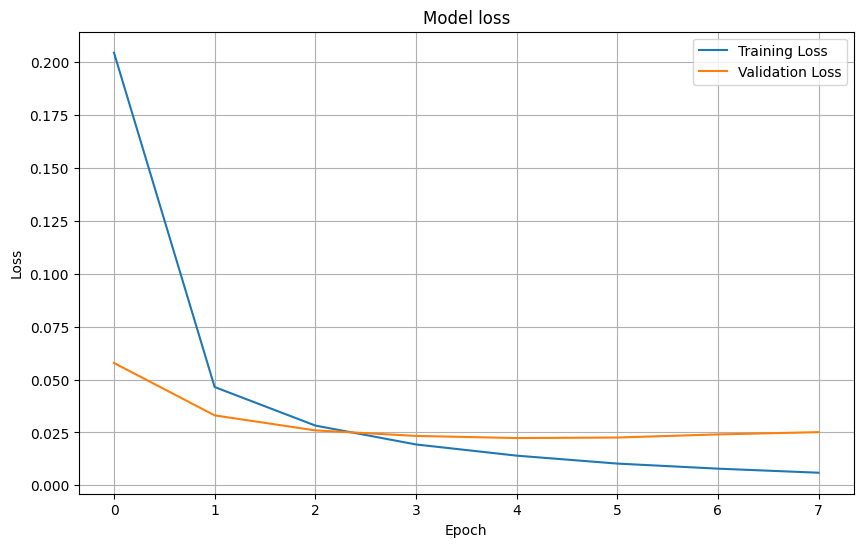

In [48]:
# Plot learning curves

plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(keras_model_history.history['loss'], label='Training Loss')
plt.plot(keras_model_history.history['val_loss'], label='Validation Loss')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

In [49]:
# Make predictions on input data (X_test) in form of probabilities

keras_probabilities = keras_model.predict(X_test)
keras_probabilities[:5]

208/208 [==============================] - 1s 4ms/step


array([[4.7043272e-07],
       [2.3749596e-08],
       [5.0812923e-05],
       [4.1984212e-02],
       [4.2707095e-01]], dtype=float32)

In [50]:
# Turn prediction probabilities into single-dimension tensor of floats

# squeeze removes single dimensions
keras_prediction = tf.squeeze(tf.round(keras_probabilities))
keras_prediction[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)>

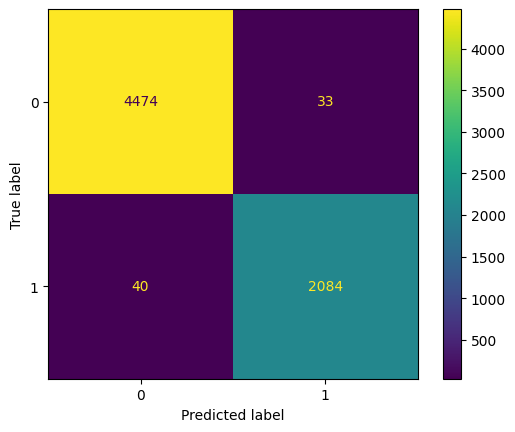

In [51]:
# Plot confusion matrix

keras_cm = confusion_matrix(y_test, keras_prediction)
keras_cm_plot = ConfusionMatrixDisplay(confusion_matrix=keras_cm)

keras_cm_plot.plot()
plt.show()

In [52]:
# Predictions from the model on the test set
y_pred = keras_model.predict(X_test)

# Converting probabilities to classes (assuming a threshold of 0.5)
y_pred_classes = (y_pred > 0.5).astype(int)

# Printing the classification report
print(classification_report(y_test, y_pred_classes))

208/208 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4507
           1       0.98      0.98      0.98      2124

    accuracy                           0.99      6631
   macro avg       0.99      0.99      0.99      6631
weighted avg       0.99      0.99      0.99      6631



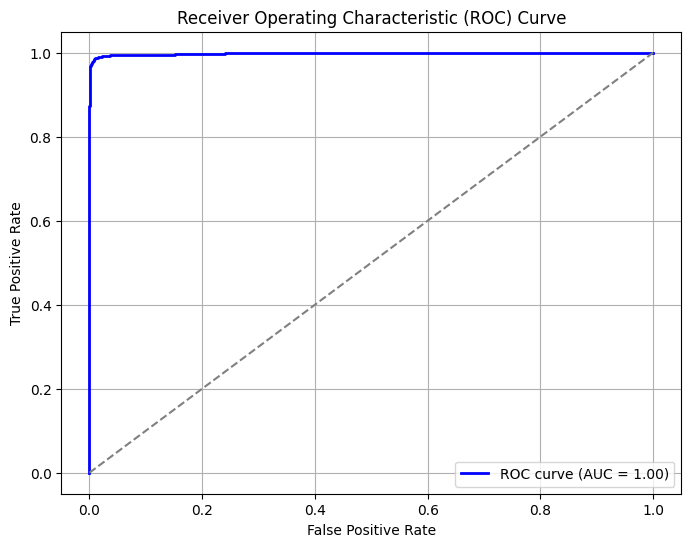

In [53]:
 #AUC -  ROC Curve

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Set labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Set title and legend
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

Excellent result.